In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/AI _for_Climate_Change

/content/drive/MyDrive/AI _for_Climate_Change


In [ ]:
pip install -q rasterio geopandas scikit-learn xgboost matplotlib shapely


In [ ]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, roc_curve
import tensorflow as tf
from tensorflow.keras import layers, models

In [ ]:
import os
import numpy as np
import rasterio
from rasterio.enums import Resampling

# Define path and filenames
data_path = '/content/drive/MyDrive/AI _for_Climate_Change/flood_data'
raster_files = [
    'elevation.tif', 'twi.tif', 'spi.tif', 'slope.tif', 'tpi.tif', 'aspect.tif', 'curvature.tif',
    'distanceToRivers.tif','distanceToRoads.tif', 'rainfall.tif', 'soilph.tif',
    'temperature.tif','lulc.tif', 'drainagedensity.tif'

]

target_file = 'flood.tif'


# Use the first raster as reference for alignment
ref_path = os.path.join(data_path, raster_files[0])
with rasterio.open(ref_path) as ref:
    ref_meta = ref.meta
    ref_transform = ref.transform
    ref_crs = ref.crs
    ref_shape = ref.shape

# Function to read, align, and flatten raster
def read_and_align_raster(path):
    with rasterio.open(path) as src:
        if src.shape != ref_shape:
            print(f"Resampling {os.path.basename(path)} from {src.shape} to {ref_shape}")
            data = src.read(
                out_shape=(1, ref_shape[0], ref_shape[1]),
                resampling=Resampling.bilinear
            )
        else:
            data = src.read(1)

        data = np.where(data == src.nodata, np.nan, data)
        return data.flatten()


# Load and stack features
X_data = []
for f in raster_files:
    print(f"Reading {f}")
    raster_path = os.path.join(data_path, f)
    X_data.append(read_and_align_raster(raster_path))

X = np.stack(X_data, axis=1)

# Load target (flood history)
y = read_and_align_raster(os.path.join(data_path, target_file))


Reading elevation.tif
Reading twi.tif
Reading spi.tif
Reading slope.tif
Reading tpi.tif
Reading aspect.tif
Reading curvature.tif
Reading distanceToRivers.tif
Reading distanceToRoads.tif
Reading rainfall.tif
Reading soilph.tif
Reading temperature.tif
Reading lulc.tif
Reading drainagedensity.tif


In [ ]:
from rasterio.enums import Resampling

# Get reference raster (we use elevation.tif as the baseline)
ref_path = os.path.join(data_path, 'rainfall.tif')
with rasterio.open(ref_path) as ref:
    ref_shape = ref.read(1).shape
    ref_transform = ref.transform
    ref_crs = ref.crs

# Function to read and resample raster to match reference shape
def read_and_match_raster(path, ref_shape, ref_transform, ref_crs):
    with rasterio.open(path) as src:
        data = src.read(
            1,
            out_shape=ref_shape,
            resampling=Resampling.bilinear  # Resample if needed
        )
        data = np.where(data == src.nodata, np.nan, data)
        return data.flatten()

# Load and match all features
X_data = []
for f in raster_files:
    print(f"Reading and resampling {f}")
    raster_path = os.path.join(data_path, f)
    X_data.append(read_and_match_raster(raster_path, ref_shape, ref_transform, ref_crs))

# Stack all arrays into (n_samples, n_features)
X = np.stack(X_data, axis=1)

# Load and align target (flood_history)
y = read_and_match_raster(os.path.join(data_path, target_file), ref_shape, ref_transform, ref_crs)

Reading and resampling elevation.tif
Reading and resampling twi.tif
Reading and resampling spi.tif
Reading and resampling slope.tif
Reading and resampling tpi.tif
Reading and resampling aspect.tif
Reading and resampling curvature.tif
Reading and resampling distanceToRivers.tif
Reading and resampling distanceToRoads.tif
Reading and resampling rainfall.tif
Reading and resampling soilph.tif
Reading and resampling temperature.tif
Reading and resampling lulc.tif
Reading and resampling drainagedensity.tif


In [ ]:
import pandas as pd

nan_stats = pd.DataFrame({
    'Feature': raster_files,
    'NaN Pixels': [np.isnan(arr).sum() for arr in X_data],
    'Total Pixels': len(X_data[0]),
})
nan_stats['Percent Missing'] = (nan_stats['NaN Pixels'] / nan_stats['Total Pixels']) * 100

print(nan_stats.sort_values('Percent Missing', ascending=False))


                 Feature  NaN Pixels  Total Pixels  Percent Missing
10            soilph.tif     2042378       5737875        35.594676
1                twi.tif     2027228       5737875        35.330641
5             aspect.tif     2027228       5737875        35.330641
3              slope.tif     2027228       5737875        35.330641
2                spi.tif     2027228       5737875        35.330641
9           rainfall.tif     2019601       5737875        35.197717
11       temperature.tif     2016933       5737875        35.151219
0          elevation.tif     2016876       5737875        35.150225
4                tpi.tif     2016876       5737875        35.150225
6          curvature.tif     2016876       5737875        35.150225
8    distanceToRoads.tif     2016876       5737875        35.150225
7   distanceToRivers.tif     2016876       5737875        35.150225
12              lulc.tif     2016876       5737875        35.150225
13   drainagedensity.tif     2016876       57378

In [ ]:
jjj

NameError: name 'jjj' is not defined

In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Keep only where target is not NaN
mask_y = ~np.isnan(y)
X_clean = X_imputed[mask_y]
y_clean = y[mask_y]

print("Original shape of X_imputed:", X_imputed.shape)
print("Original shape of mask_y:", mask_y.shape)
print("Cleaned shape of X:", X_clean.shape)
print("Cleaned shape of y:", y_clean.shape)

Original shape of X: (5737875, 14)
Original shape of y: (5737875,)
Cleaned shape of X: (220901, 14)
Cleaned shape of y: (220901,)


In [ ]:
nan_report = pd.DataFrame({
    'Feature': raster_files,
    'NaN Count': [np.isnan(x).sum() for x in X_data],
    'Percent Missing': [np.isnan(x).sum() / len(x) * 100 for x in X_data]
}).sort_values(by='Percent Missing', ascending=False)

print(nan_report)

                 Feature  NaN Count  Percent Missing
10            soilph.tif    2042378        35.594676
1                twi.tif    2027228        35.330641
5             aspect.tif    2027228        35.330641
3              slope.tif    2027228        35.330641
2                spi.tif    2027228        35.330641
9           rainfall.tif    2019601        35.197717
11       temperature.tif    2016933        35.151219
0          elevation.tif    2016876        35.150225
4                tpi.tif    2016876        35.150225
6          curvature.tif    2016876        35.150225
8    distanceToRoads.tif    2016876        35.150225
7   distanceToRivers.tif    2016876        35.150225
12              lulc.tif    2016876        35.150225
13   drainagedensity.tif    2016876        35.150225


In [ ]:
import numpy as np
from scipy.ndimage import generic_filter

def interpolate_raster_nans(raster, method='median'):
    """
    Fill NaN values in 2D or 3D raster using spatial interpolation (median or mean of neighboring pixels).

    raster: np.ndarray
        A 2D (H, W) raster OR a 3D raster (H, W, Bands)
    method: str
        'median' (default) or 'mean'
    Returns:
        Interpolated raster (same shape as input)
    """

    def fill_func(values):
        center = values[len(values) // 2]
        if np.isnan(center):
            valid = values[~np.isnan(values)]
            return np.median(valid) if method == 'median' else np.mean(valid) if valid.size > 0 else np.nan
        return center

    if raster.ndim == 2:
        return generic_filter(raster, fill_func, size=3, mode='mirror')

    elif raster.ndim == 3:
        filled = np.empty_like(raster)
        for i in range(raster.shape[2]):
            print(f"Filling band {i+1}/{raster.shape[2]}")
            filled[:, :, i] = generic_filter(raster[:, :, i], fill_func, size=3, mode='mirror')
        return filled

    else:
        raise ValueError("Input must be 2D or 3D array")


In [ ]:
H, W = ref_shape  # Get shape of your raster (e.g. 2145 x 2675)
X_raster = X.reshape(H, W, 14)  # Convert X to 3D raster format

# Interpolate
X_filled_raster = interpolate_raster_nans(X_raster, method='median')

# Flatten back for model training
X_imputed = X_filled_raster.reshape(-1, 14)


Filling band 1/14


/usr/local/lib/python3.11/dist-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Filling band 2/14
Filling band 3/14
Filling band 4/14
Filling band 5/14
Filling band 6/14
Filling band 7/14
Filling band 8/14
Filling band 9/14
Filling band 10/14
Filling band 11/14
Filling band 12/14
Filling band 13/14
Filling band 14/14


In [ ]:
y_raster = y.reshape(H, W)  # Convert y to 2D raster
y_filled_raster = interpolate_raster_nans(y_raster, method='median')
y_imputed = y_filled_raster.flatten()  # Flatten for training


In [ ]:
# # Remove rows with NaN in any feature or target
mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y_imputed)
X_clean = X_imputed[mask]
y_clean = y_imputed[mask]
#


print("Correct mask length:", mask.shape)
print("Valid pixels (should match y_prob_rf):", np.sum(mask))  # Should be 57571


Correct mask length: (5737875,)
Valid pixels (should match y_prob_rf): 440245


In [ ]:
X_clean.shape

In [ ]:
y_clean.shape

In [ ]:
# Perform train-test split

X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.3, random_state=42, stratify=y_clean
)
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (308171, 14)
Shape of X_test: (132074, 14)
Shape of y_train: (308171,)
Shape of y_test: (132074,)


In [ ]:
#RANDOM FOREST
import numpy as np # Import numpy

# Round values and convert to int
y_train = np.round(y_train).astype(int)
y_test = np.round(y_test).astype(int)


rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]

In [ ]:
# XGBOOST

xgb_model = XGBClassifier(
    n_estimators=100,
    eval_metric='logloss',  # Still needed to suppress eval warning
    random_state=42
)

xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

In [ ]:
from lightgbm import LGBMClassifier

# LIGHTGBM
lgb_model = LGBMClassifier(
    n_estimators=100,
    objective='binary',       # for binary classification
    random_state=42
)

lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)
y_prob_lgb = lgb_model.predict_proba(X_test)[:, 1]


[LightGBM] [Info] Number of positive: 130317, number of negative: 177854
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.051162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3138
[LightGBM] [Info] Number of data points in the train set: 308171, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.422872 -> initscore=-0.310993
[LightGBM] [Info] Start training from score -0.310993


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


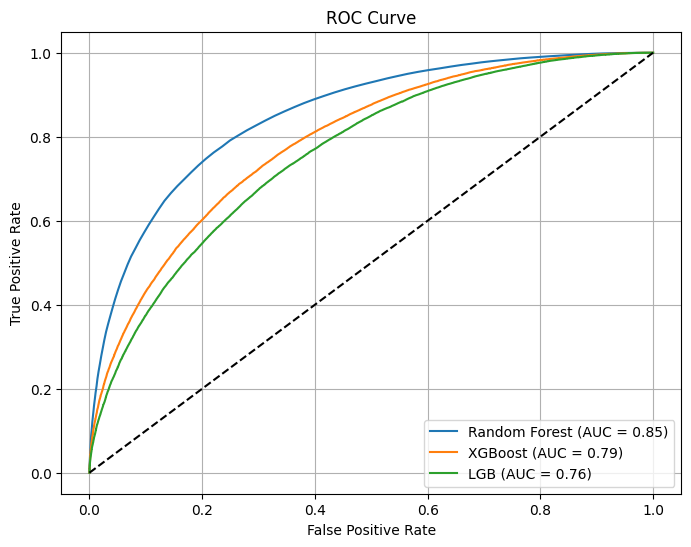

In [ ]:
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_prob_lgb)


plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, label='Random Forest (AUC = {:.2f})'.format(roc_auc_score(y_test, y_prob_rf)))
plt.plot(fpr_xgb, tpr_xgb, label='XGBoost (AUC = {:.2f})'.format(roc_auc_score(y_test, y_prob_xgb)))
plt.plot(fpr_lgb, tpr_lgb, label='LGB (AUC = {:.2f})'.format(roc_auc_score(y_test, y_prob_lgb)))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid()
plt.show()


RF Feature importance plot saved to: /content/drive/MyDrive/AI _for_Climate_Change/rf_feature_importance.png


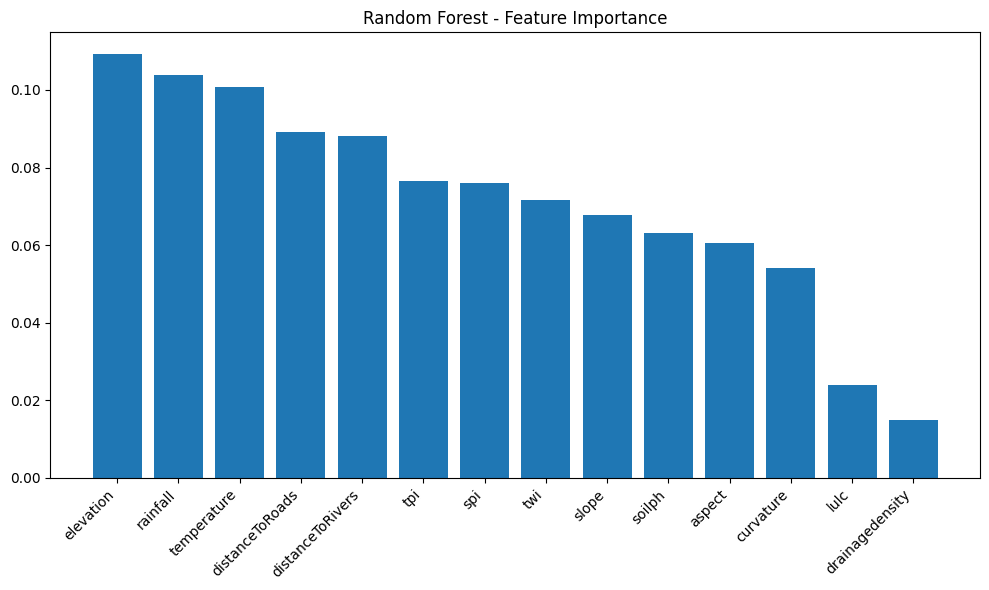

XG Feature importance plot saved to: /content/drive/MyDrive/AI _for_Climate_Change/xgb_feature_importance.png


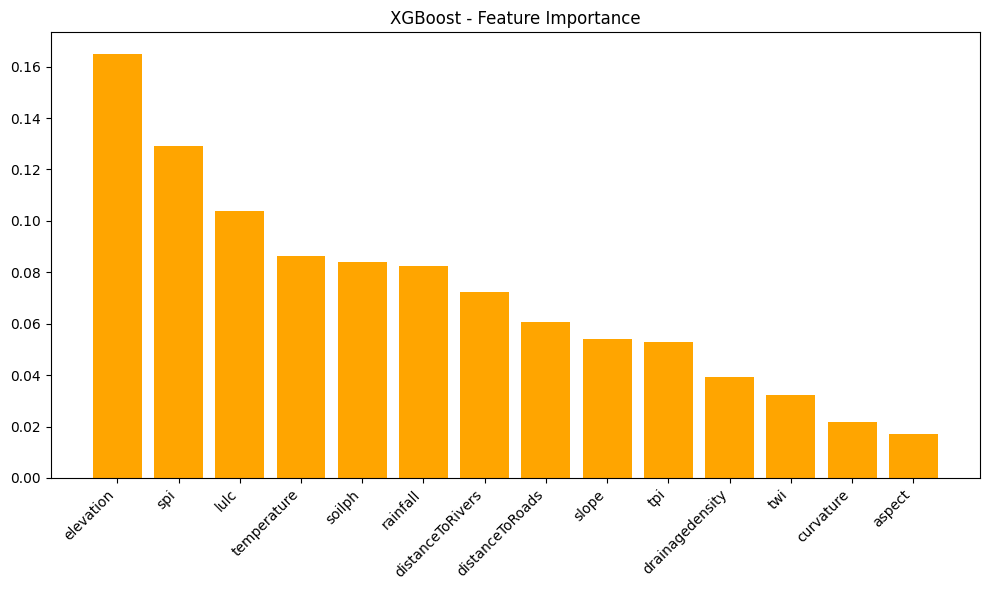

LGB Feature importance plot saved to: /content/drive/MyDrive/AI _for_Climate_Change/lgb_feature_importance.png


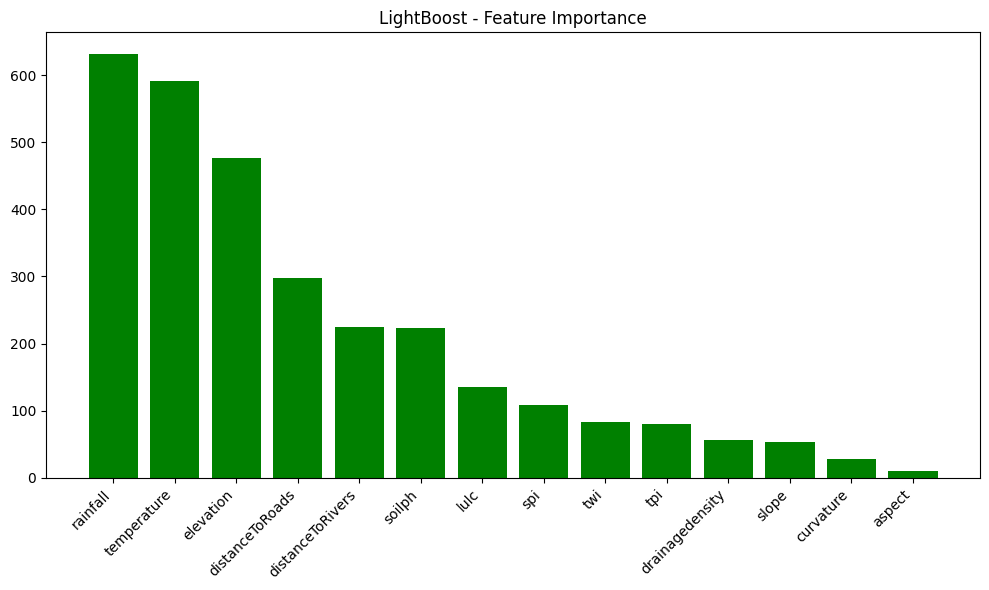

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Feature names (remove '.tif' for better display)
feature_names = [f.replace('.tif', '') for f in raster_files]

# --- Random Forest Feature Importance ---
importances_rf = rf_model.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Random Forest - Feature Importance")
plt.bar(range(len(importances_rf)), importances_rf[indices_rf], align='center')
plt.xticks(range(len(importances_rf)), [feature_names[i] for i in indices_rf], rotation=45, ha='right')
plt.tight_layout()
rf_plot_path = '/content/drive/MyDrive/AI _for_Climate_Change/rf_feature_importance.png'
plt.savefig(rf_plot_path, dpi=300)
print(f"RF Feature importance plot saved to: {rf_plot_path}")
plt.show()


# --- XGBoost Feature Importance ---
importances_xgb = xgb_model.feature_importances_
indices_xgb = np.argsort(importances_xgb)[::-1]

plt.figure(figsize=(10, 6))
plt.title("XGBoost - Feature Importance")
plt.bar(range(len(importances_xgb)), importances_xgb[indices_xgb], color='orange', align='center')
plt.xticks(range(len(importances_xgb)), [feature_names[i] for i in indices_xgb], rotation=45, ha='right')
plt.tight_layout()
xgb_plot_path = '/content/drive/MyDrive/AI _for_Climate_Change/xgb_feature_importance.png'
plt.savefig(xgb_plot_path, dpi=300)
print(f"XG Feature importance plot saved to: {xgb_plot_path}")
plt.show()


# --- LightBoost Feature Importance ---
# Use the lgb_model from cell U5nn8HInpD1t as the grid search in cell 6rL72a0s4_xm was interrupted
importances_lgb = lgb_model.feature_importances_
# # importances_lgb = lgb_model.booster_.feature_importance(importance_type='split')
# importances_lgb = importances_lgb / np.sum(importances_lgb)

indices_lgb = np.argsort(importances_lgb)[::-1]

plt.figure(figsize=(10, 6))
plt.title("LightBoost - Feature Importance")
plt.bar(range(len(importances_lgb)), importances_lgb[indices_lgb], color='green', align='center') # Changed color to green
plt.xticks(range(len(importances_lgb)), [feature_names[i] for i in indices_lgb], rotation=45, ha='right')
plt.tight_layout()
lgb_plot_path = '/content/drive/MyDrive/AI _for_Climate_Change/lgb_feature_importance.png'
plt.savefig(lgb_plot_path, dpi=300)
print(f"LGB Feature importance plot saved to: {lgb_plot_path}")
plt.show()

In [ ]:
jj

In [ ]:
# Predict on all valid pixels
y_prob_full = rf_model.predict_proba(X_imputed)[:, 1]  # All X, fully imputed


In [ ]:
# Reshape 1D predictions to 2D raster
prediction_2d = y_prob_full.reshape(ref_shape)  # ref_shape = (height, width)


In [ ]:
import geopandas as gpd
from rasterio.mask import mask

# Load Nigeria shapefile
nigeria_shape = gpd.read_file("/content/drive/MyDrive/AI _for_Climate_Change/NGA_adm0.shp")  # Update this path

# Reproject to match raster CRS
with rasterio.open(ref_path) as src:
    nigeria_shape = nigeria_shape.to_crs(src.crs)
    nigeria_geom = [feature["geometry"] for feature in nigeria_shape.__geo_interface__['features']]


In [ ]:
# Save full prediction to temp file
temp_path = os.path.join(data_path, "temp_full_prediction.tif")
with rasterio.open(ref_path) as src:
    profile = src.profile

profile.update(dtype=rasterio.float32, count=1, compress='lzw')

with rasterio.open(temp_path, 'w', **profile) as dst:
    dst.write(prediction_2d.astype(np.float32), 1)


In [ ]:
# Now reopen and apply the mask
with rasterio.open(temp_path) as src:
    out_image, out_transform = mask(src, nigeria_geom, crop=False, filled=True, nodata=np.nan)
    out_meta = src.meta.copy()

# Update metadata
out_meta.update({
    "driver": "GTiff",
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform,
    "nodata": np.nan
})

# Export the final masked raster
masked_output_path = os.path.join(data_path, "flood_prediction_rf_masked.tif")
with rasterio.open(masked_output_path, "w", **out_meta) as dest:
    dest.write(out_image.astype(np.float32))

print("Masked flood prediction exported to:", masked_output_path)


Masked flood prediction exported to: /content/drive/MyDrive/AI _for_Climate_Change/flood_data/flood_prediction_rf_masked.tif


In [ ]:
# Output path
output_path = os.path.join(data_path, 'flood_prediction_rf_full.tif')

# Load metadata from reference raster
with rasterio.open(ref_path) as src:
    profile = src.profile

# Update metadata
profile.update(
    dtype=rasterio.float32,
    count=1,
    compress='lzw'
)

# Write prediction raster
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(prediction_2d.astype(np.float32), 1)

print("Flood probability map exported to:", output_path)

Flood probability map exported to: /content/drive/MyDrive/AI _for_Climate_Change/flood_data/flood_prediction_rf_full.tif


In [ ]:
# Prepare full-size prediction array
full_prediction = np.full(valid_mask.shape, np.nan)

# Fill only valid pixels
full_prediction[valid_mask] = y_prob_full

NameError: name 'valid_mask' is not defined

In [ ]:
# Reshape to raster
prediction_2d = full_prediction.reshape(ref_shape)

# Save as GeoTIFF
output_path = os.path.join(data_path, 'flood_prediction_rf.tif')

with rasterio.open(ref_path) as src:
    profile = src.profile

profile.update(dtype=rasterio.float32, count=1, compress='lzw')

with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(prediction_2d.astype(np.float32), 1)

print("GeoTIFF saved:", output_path)


In [ ]:
import numpy as np
import rasterio
import os

# ✅ Step 1: Predict on all X where y is not NaN
X_for_prediction = X_imputed[mask_y]
y_prob_rf = rf_model.predict_proba(X_for_prediction)[:, 1]  # Probability of flood class

# ✅ Step 2: Create a full prediction array (same size as X_imputed)
full_prediction = np.full(X_imputed.shape[0], np.nan)
full_prediction[mask_y] = y_prob_rf

# ✅ Step 3: Reshape to original raster shape
prediction_2d = full_prediction.reshape(ref_shape)

# ✅ Step 4: Save as GeoTIFF
output_path = os.path.join(data_path, 'flood_prediction_rf.tif')

# Load raster metadata
with rasterio.open(ref_path) as src:
    profile = src.profile

# Update profile for prediction export
profile.update(dtype=rasterio.float32, count=1, compress='lzw')

# Export the prediction
with rasterio.open(output_path, 'w', **profile) as dst:
    dst.write(prediction_2d.astype(np.float32), 1)

print("Random Forest flood prediction exported as:", output_path)


Random Forest flood prediction exported as: /content/drive/MyDrive/AI _for_Climate_Change/flood_data/flood_prediction_rf.tif
